In [1]:
import gtfs_kit as gk
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from funcs import process_line, show_headways, compute_scheduled_headways
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read gtfs3Sept.zip
file3s = Path('./gtfs/gtfs3Sept.zip')
feed3s = (gk.read_feed(file3s, dist_units='m'))
feed3s.validate()

,type,message,table,rows
0,warning,Feed expired,calendar/calendar_dates,[]


In [4]:
# Read gtfs23Sept.zip
file23s = Path('./gtfs/gtfs23Sept.zip')
feed23s = (gk.read_feed(file23s, dist_units='m'))
feed23s.validate()

,type,message,table,rows
0,warning,Feed expired,calendar/calendar_dates,[]


In [11]:
# Our data goes from 2021-09-05 to 2021-09-21
print(gk.calendar.get_week(feed3s, 1))
print(gk.calendar.get_week(feed3s, 2))
print(gk.calendar.get_week(feed3s, 3))
print(gk.calendar.get_week(feed3s, 4))
print(gk.calendar.get_week(feed3s, 5))
print(gk.calendar.get_week(feed23s, 1)[:2])
print(min(gk.calendar.get_dates(feed23s)))
# As we can see, we need both feeds to get the whole schedule, so we'll merge them

['20210823', '20210824', '20210825', '20210826', '20210827', '20210828', '20210829']
['20210830', '20210831', '20210901', '20210902', '20210903', '20210904', '20210905']
['20210906', '20210907', '20210908', '20210909', '20210910', '20210911', '20210912']
['20210913', '20210914', '20210915', '20210916', '20210917', '20210918', '20210919']
[]
['20210920', '20210921']
20210920


In [5]:
# Get all dates matching our data
our_dates = {}
our_dates['3s'] = gk.calendar.get_week(feed3s, 3)
our_dates['3s'].extend(gk.calendar.get_week(feed3s, 4))
our_dates['23s'] = gk.calendar.get_week(feed23s, 1)[:2]
print(our_dates)

# Get all lines
lines = {}
lines['3s'] = gk.routes.get_routes(feed3s)
lines['23s'] = gk.routes.get_routes(feed23s)
print(lines['3s'].route_id.unique())

# Map each line to its short_name by joining route_id and route_short_name in routes.txt
short_names = {}
short_names['3s'] = gk.routes.get_routes(feed3s)[['route_id', 'route_short_name']].reset_index(drop=True)
short_names['23s'] = gk.routes.get_routes(feed23s)[['route_id', 'route_short_name']].reset_index(drop=True)

# Get the inverted map: short_name -> route_id
short_names_inv = {}
short_names_inv['3s'] = short_names['3s'].set_index('route_short_name').to_dict()['route_id']
short_names_inv['23s'] = short_names['23s'].set_index('route_short_name').to_dict()['route_id']

# Get all short_names from real data
short_names_real = [44, 4, 29, 48, 74, 66, 76, 81, 65, 61, 83, 82, 58, 70, 53, 87, 57, 86, 34, 50, 17, 59, 33, 19, 60, 42, 36, 43, 6, 89, 51, 75, 28, 54, 69, 55, 88, 25, 21, 46, 72, 56, 9, 79, 39, 95, 97, 62, 5, 63, 41, 14, 98, 8, 13, 80, 93, 2, 47, 45, 77, 27, 49, 71, 20, 92, 38, 37, 3, 78, 12, 7, 64, 1]
# transform to str
short_names_real = [str(x) for x in short_names_real]

print(short_names_real)

{'3s': ['20210906', '20210907', '20210908', '20210909', '20210910', '20210911', '20210912', '20210913', '20210914', '20210915', '20210916', '20210917', '20210918', '20210919'], '23s': ['20210920', '20210921']}
['2' '4' '5' '10' '1' '3' '6' '11' '12' '18' '20' '21' '22' '13' '23' '19'
 '25' '93' '27' '28' '29' '76' '32' '34' '35' '37' '39' '41' '43' '45'
 '36' '40' '44' '30' '47' '48' '49' '50' '15' '31' '52' '53' '26' '54'
 '55' '56' '57' '58' '59' '9' '60' '62' '63' '64' '17' '38' '65' '66' '98'
 '51' '68' '69' '70' '71' '72' '61' '42' '14' '16' '91' '73' '46' '89'
 '24' '74' '90' '33' '7' '75' '77' '8' '67' '95' '96' '97' '94' '78' '80'
 '79' '82' '81' '83' '85' '84' '86' '92' '87' '88']
['44', '4', '29', '48', '74', '66', '76', '81', '65', '61', '83', '82', '58', '70', '53', '87', '57', '86', '34', '50', '17', '59', '33', '19', '60', '42', '36', '43', '6', '89', '51', '75', '28', '54', '69', '55', '88', '25', '21', '46', '72', '56', '9', '79', '39', '95', '97', '62', '5', '63', '41'

In [7]:
print(short_names['23s'].route_short_name.unique())

['1' '2' '3' '4' '5' '6' '7' '8' '9' '12' '13' '14' '17' '19' '20' '21'
 '25' '27' '28' '29' '33' '34' '36' '37' '38' '39' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58'
 '59' '60' '61' '62' '63' '64' '65' '66' '69' '70' '71' '72' '74' '75'
 '76' '77' '78' '79' '80' '81' '82' '83' '86' '87' '88' '89' '92' '93'
 '95' '97' '98' 'M1' 'T51' 'T81' 'T82' 'N04' 'N05' 'N06' 'N08' 'N09' 'N10'
 'N11' 'N12' 'N13' 'N16' 'N18']


In [11]:
schedules_lines = {}
for line_sn in short_names_real:
    print(line_sn)
    schedules_lines[line_sn] = pd.read_csv(f'./schedules_line/schedule_{line_sn}.csv')
    # for each short_name, get the route_id for each feed if it exists
    if line_sn in short_names['3s'].route_short_name.unique():
        rid3s = short_names_inv['3s'][line_sn]
        for date in our_dates['3s']:
            timetable = process_line(feed3s, rid3s, [date])
            timetable['date'] = date
            if line_sn in schedules_lines:
                schedules_lines[line_sn] = pd.concat([schedules_lines[line_sn], timetable])
            else:
                schedules_lines[line_sn] = timetable
    if line_sn in short_names['23s'].route_short_name.unique():
        rid23s = short_names_inv['23s'][line_sn]
        for date in our_dates['23s']:
            timetable = process_line(feed23s, rid23s, [date])
            timetable['date'] = date
            if line_sn in schedules_lines:
                schedules_lines[line_sn] = pd.concat([schedules_lines[line_sn], timetable])
            else:
                schedules_lines[line_sn] = timetable
                
    # save it to csv
    schedules_lines[line_sn].to_csv(f'./schedules_line/schedule_{line_sn}.csv', index=False)

44
4
29
48
74
66
76
81
65
61
83
82
58
70
53
87
57
86
34
50
17
59
33
19
60
42
36
43
6
89
51
75
28
54
69
55
88
25
21
46
72
56
9
79
39
95
97
62
5
63
41
14
98
8
13
80
93
2
47
45
77
27
49
71
20
92
38
37
3
78
12
7
64
1


In [7]:
for line_sn in short_names_real:
    print(line_sn)
    # Read the schedule
    schedule = pd.read_csv(f'./schedules_line/schedule_{line_sn}.csv')
    # Get headways for each line
    headways = compute_scheduled_headways(schedule)
    # save headways to csv
    headways.to_csv(f'./headways_line/headways_{line_sn}.csv', index=False)

44
4
29
48
74
66
76
81
65
61
83
82
58
70
53
87
57
86
34
50
17
59
33
19
60
42
36
43
6
89
51
75
28
54
69
55
88
25
21
46
72
56
9
79
39
95
97
62
5
63
41
14
98
8
13
80
93
2
47
45
77
27
49
71
20
92
38
37
3
78
12
7
64
1


In [12]:
# read all schedules and add the line number to the dataframe
for line_sn in short_names_real:
    schedules_lines[line_sn] = pd.read_csv(f'./schedules_line/schedule_{line_sn}.csv')
    schedules_lines[line_sn]['line'] = line_sn
    # save it again
    schedules_lines[line_sn].to_csv(f'./schedules_line/schedule_{line_sn}.csv', index=False)

In [13]:
# read all headways and add the line number to the dataframe
for line_sn in short_names_real:
    headways = pd.read_csv(f'./headways_line/headways_{line_sn}.csv')
    headways['line'] = line_sn
    # save it again
    headways.to_csv(f'./headways_line/headways_{line_sn}.csv', index=False)

In [20]:
# Let's try to visualize the headways for a line
tt = process_line(feed3s, '34', ['20210906'])
print(tt)
# get some stop_id from the timetable
stop_id = tt.stop_id.unique()
#show_headways(stop_id, tt, direction_id=1)

         trip_headsign  direction_id stop_id departure_time  headway  \
950320     SAINTE-ANNE             0    1233       06:18:00        0   
950282  R.P. SOUVERAIN             0    1233       06:34:00      960   
950184     SAINTE-ANNE             0    1233       06:48:00      840   
950975  R.P. SOUVERAIN             0    1233       06:53:00      300   
950993     SAINTE-ANNE             0    1233       06:59:00      360   
...                ...           ...     ...            ...      ...   
946234  PORTE DE NAMUR             1    6432       23:05:00     1200   
946074  PORTE DE NAMUR             1    6432       23:23:00     1080   
946056  PORTE DE NAMUR             1    6432       23:43:00     1200   
946038  PORTE DE NAMUR             1    6432       24:03:00     1200   
946020  PORTE DE NAMUR             1    6432       24:23:00     1200   

              class  
950320  punctuality  
950282  punctuality  
950184  punctuality  
950975   regularity  
950993   regularity  
...

['1233' '1706' '1712' '1713' '1714' '1715' '1716' '1718' '1719' '1720'
 '1728' '1729' '1731' '1733' '1824' '2058' '2291' '2725' '2727' '2728'
 '6433' '1278' '1751' '1756' '1757' '1758' '1760' '1762' '1764' '1769'
 '1776' '1777' '1779' '1983' '2009' '2290' '2752' '2753' '4367' '4952'
 '6432']


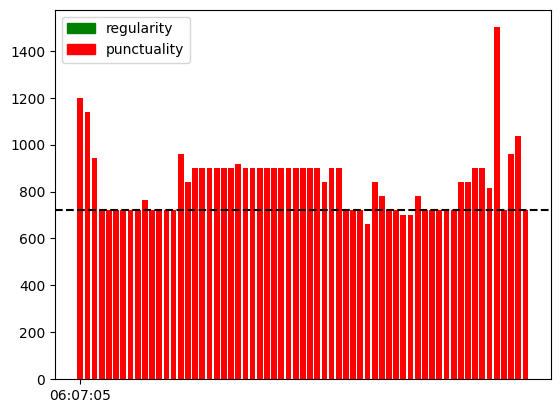

In [30]:
print(stop_id)
show_headways('2753', tt, direction_id=1) # 2296, 6444

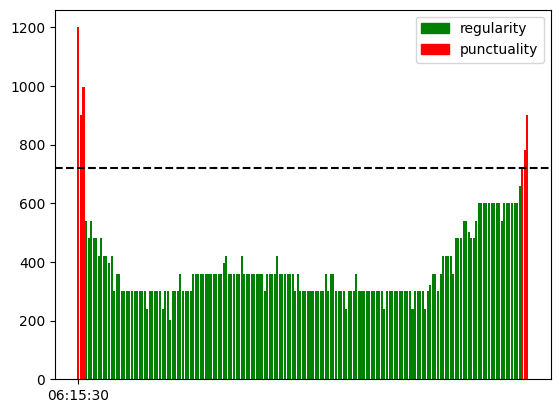

In [9]:
show_headways('1597', tt, direction_id=0)

In [6]:
# Now we are going to reduce the number of lines to 10, by selecting those that
# go through GARE CENTRALE

# from stops.txt get all stop_id with stop_name == 'GARE CENTRALE'
stops = pd.read_csv('gtfs23Sept/stops.txt')
stops = stops.loc[stops['stop_name'] == 'GARE CENTRALE']['stop_id']

# read stop_times.txt and get all trip_id that pass through GARE CENTRALE
stop_times = pd.read_csv('gtfs23Sept/stop_times.txt')
stop_times = stop_times.loc[stop_times['stop_id'].isin(stops)]['trip_id']

# read trips.txt and get all route_id that have a trip_id in stop_times
trips = pd.read_csv('gtfs23Sept/trips.txt')
trips = trips.loc[trips['trip_id'].isin(stop_times)]['route_id'].unique()

# read the routes.txt and map the route_id to the short_route_name
lines_GC = pd.read_csv('gtfs23Sept/routes.txt')
lines_GC = lines_GC.loc[lines_GC['route_id'].isin(trips)]['route_short_name'].unique()

filtered_lines = []
for line in lines_GC:
    if 'N' not in line:
        filtered_lines.append(line)

# line 52 is not in the real data, so we remove it
filtered_lines = [x for x in filtered_lines if x in short_names_real]
print(filtered_lines)


['1', '5', '29', '38', '63', '65', '66', '71', '89']


In [7]:
# Now, we are merging the schedules of the 10 lines that go through GARE CENTRALE
# as well as the headways
for line_sn in filtered_lines:
    schedule = pd.read_csv(f'schedules_line/schedule_{line_sn}.csv')
    headways = pd.read_csv(f'headways_line/headways_{line_sn}.csv')
    if 'schedules' in locals():
        schedules = pd.concat([schedules, schedule])
        headways_all = pd.concat([headways_all, headways])
    else:
        schedules = schedule
        headways_all = headways

# save the schedules and headways to csv
schedules.to_csv('./schedules_filtered.csv', index=False)
headways_all.to_csv('./headways_filtered.csv', index=False)

In [30]:
# We are also going to reduce the gtfs files to only the lines that go through GARE CENTRALE
# and save them to a new folder called gtfs_filtered

# First step: get all the stop_id that are in the schedules_filtered.csv and reduce stops.txt
stops = schedules.stop_id.unique()
stops_gtfs = pd.read_csv('gtfs23Sept/stops.txt')
stop_ids = pd.DataFrame(stops_gtfs['stop_id'])
#       remove the last character of the stop_id if it is a letter and convert to int
stop_ids['stop_id'] = stop_ids['stop_id'].apply(lambda x: x[:-1] if x[-1].isalpha() else x)
stop_ids['stop_id'] = stop_ids['stop_id'].astype('int')
#       we want those stop_id that are in the schedules_filtered.csv
stops_gtfs = stops_gtfs.loc[stop_ids.stop_id.isin(stops)]
stops_gtfs.to_csv('gtfs_filtered/stops.txt', index=False)

# Second step: get all the route_short_name whose route_id is in the schedules_filtered.csv
# and reduce routes.txt
lines = schedules.line.unique()
lines = [str(x) for x in lines]
lines_gtfs = pd.read_csv('gtfs23Sept/routes.txt')
lines_gtfs = lines_gtfs.loc[lines_gtfs['route_short_name'].isin(lines)]
lines_gtfs.to_csv('gtfs_filtered/routes.txt', index=False)

# Third step: get all route_id from lines_gtfs and reduce trips.txt
lines_gtfs = pd.read_csv('gtfs_filtered/routes.txt')
lines_gtfs = lines_gtfs['route_id'].unique()
trips_gtfs = pd.read_csv('gtfs23Sept/trips.txt')
trips_gtfs = trips_gtfs.loc[trips_gtfs['route_id'].isin(lines_gtfs)]
trips_gtfs.to_csv('gtfs_filtered/trips.txt', index=False)

# Forth step: get all trip_id from trips_gtfs and reduce stop_times.txt
trip_ids = trips_gtfs['trip_id'].unique()
stop_times_gtfs = pd.read_csv('gtfs23Sept/stop_times.txt')
stop_times_gtfs = stop_times_gtfs.loc[stop_times_gtfs['trip_id'].isin(trip_ids)]
stop_times_gtfs.to_csv('gtfs_filtered/stop_times.txt', index=False)

# Fifth step: get all service_id from trips_gtfs and reduce calendar.txt and calendar_dates.txt
service_ids = trips_gtfs['service_id'].unique()
calendar_gtfs = pd.read_csv('gtfs23Sept/calendar.txt')
calendar_gtfs = calendar_gtfs.loc[calendar_gtfs['service_id'].isin(service_ids)]
calendar_gtfs.to_csv('gtfs_filtered/calendar.txt', index=False)
calendar_dates_gtfs = pd.read_csv('gtfs23Sept/calendar_dates.txt')
calendar_dates_gtfs = calendar_dates_gtfs.loc[calendar_dates_gtfs['service_id'].isin(service_ids)]
calendar_dates_gtfs.to_csv('gtfs_filtered/calendar_dates.txt', index=False)

In [32]:
print(stop_times_gtfs.stop_id)

['6447' '2301' '2595' '2594' '1566' '1567' '1568' '3219' '1569B' '1570'
 '1571' '3358' '3359' '3062' '6442' '1820' '2296' '6445' '3072' '3353'
 '3354' '1508' '1509' '2680' '1512' '1513' '1514' '1515' '1516' '6451'
 '1518' '1519' '1520' '1521' '1522' '3899' '1529' '1379' '1540' '1525'
 '1526' '1527' '1528' '1552' '1553' '1554' '1550' '1385' '1578' '3910'
 '1557' '1558' '1559' '1560' '1561' '6454' '1563' '3216' '1565' '3257'
 '3263B' '6648' '3259B' '3260' '3633C' '3221' '3222' '3223B' '3228' '4594'
 '1117' '4076' '1943' '1968' '1969' '1970' '1971' '1972' '1973' '5255'
 '1975' '1976' '1977' '1986' '6112' '1980' '1981' '1983' '4367B' '1776'
 '6432' '1124' '3567' '3323' '5256' '6443' '3502' '3503' '6433' '1729'
 '1233' '1906' '1909' '1916' '1917' '1918' '1919' '1920' '1921' '1942'
 '1910' '3122' '1903' '1912' '1913' '1914' '1915' '2788' '2303' '3320B'
 '1178' '4595' '3261' '1894' '3347' '1510' '1273' '1402B' '1419' '1403'
 '3251' '3266' '2247' '3761' '3762' '3763' '3766' '3765' '3274' '3285